Notebook for a simple demonstration of the python code
===================================================================

**Disclaimer:** 
This repository contains experimental software and is published for the sole purpose of giving additional background details on the respective publication. 

In [1]:
import numpy as np
import nexusformat.nexus as nx

# Laminate definition

The relevant function use an instance of the class `Laminate` in order to define the properties of the laminate in questions, including the number of plies, and the ply weights and ply-angle functions for the calculation of the lamination parameters.

In [2]:
from laminate import Laminate,generate_funcs,generate_weights

The `Laminate` class is created using two arrays `Laminate(weights,funcs)`. Here `weights` has rows corresponding to the different chosen parameter groups (usually A, D and for non-symmetric laminates also B) and columns corresponding to the individual plies.

In [3]:
num_plies = 6
weights = generate_weights(num_plies,symmetric=True,which='AD')
weights.round(3)

array([[0.167, 0.167, 0.167, 0.167, 0.167, 0.167],
       [0.005, 0.032, 0.088, 0.171, 0.282, 0.421]])

The array `funcs` has rows corresponding to the allowed ply-angles and columns corresponding to the distinct ply-angle functions.

In [4]:
angles = np.array([0,45,90,-45])
angle_functions = [
    lambda x: np.cos(2*x),
    lambda x: np.sin(2*x),
    lambda x: np.cos(4*x),
    # lambda x: np.sin(4*x)  # for [0,45,90,-45] always 0
]
funcs = generate_funcs(angles,angle_functions,deg=True,round_decimals=6)
funcs

array([[ 1.,  0.,  1.],
       [ 0.,  1., -1.],
       [-1.,  0.,  1.],
       [ 0., -1., -1.]])

An instance of `Laminate` is used to store the relevant information of a laminate.

In [5]:
laminate = Laminate(weights,funcs)
for attr in ['num_plies', 'num_angles', 'num_weights', 'num_funcs', 'weights', 'funcs']:
    val = getattr(laminate,attr)
    if not isinstance(val,int):
        attr += ".shape"
        val = val.shape
    print(f"{(attr+':'):<14} {str(val):>2}")

num_plies:      6
num_angles:     4
num_weights:    2
num_funcs:      3
weights.shape: (2, 6)
funcs.shape:   (4, 3)


For a given stacking sequence, the lamination parameters can be calculated with the function `Laminate.parameters`. As an example, target lamination parameters for the following optimizations with this function.

In [6]:
target_stack = np.array([0,1,1,2,3,3])
target_parameters = laminate.parameters(target_stack)
target_parameters

array([[ 0.      ,  0.      , -0.333333],
       [-0.166667, -0.583333, -0.648148]])

# Encoding and Hamiltonians

In [7]:
from hamiltonians import generate_loss_hamiltonian,generate_penalty_hamiltonian
from qiskit.quantum_info import SparsePauliOp

The definition of the Hamiltonians relies on an encoding of the ply states in terms of qubits, accompanied by the according outer products.

In [8]:
encoding = [(0,0),(0,1),(1,1),(1,0)]

dyad_ops = [
    SparsePauliOp.from_list([('II', 1.), ('IZ', 1.), ('ZZ', 1.), ('ZI', 1.)])/4,
    SparsePauliOp.from_list([('II', 1.), ('IZ',-1.), ('ZZ',-1.), ('ZI', 1.)])/4,
    SparsePauliOp.from_list([('II', 1.), ('IZ',-1.), ('ZZ', 1.), ('ZI',-1.)])/4,
    SparsePauliOp.from_list([('II', 1.), ('IZ', 1.), ('ZZ',-1.), ('ZI',-1.)])/4
]

ham = generate_loss_hamiltonian(laminate,target_parameters,encoding,dyad_ops)
ham.num_qubits, len(ham)

(12, 64)

The constraint matrix used in the penalty of the disorientation constraint stores which neighboring ply-angles on neighboring plies violate the disorientation constraint.

In [9]:
constraint_matrix = np.array([[0,0,1,0],
                              [0,0,0,1],
                              [1,0,0,0],
                              [0,1,0,0]])

penalty_strength = 0.25
ham_pen = generate_penalty_hamiltonian(
    laminate,constraint_matrix,encoding,dyad_ops,
    strength=penalty_strength
)
ham_pen.num_qubits, len(ham_pen)

(12, 16)

# Run experiments

The defined functions `run_qaoa` and `run_hwe` have the purpose to test how well the QAOA and HWE algorithms are able to retrieve the optimal solution. They therefore take a stacking sequence as an argument, which is then used to generate the target lamination parameters. Under real-world conditions, this stacking sequence is unknown and corresponds the the optimal solution, and the functions need to be defined differently. The functions save an HDF5 file with the results, where the destination folder and string that is used in the filename definition are passed as argument `folder` and `identifyer` to the functions.

## Run QAOA

In [10]:
from qaoa_experiment import run_qaoa

In [11]:
folder = "C:/some/folder"
identifyer = "qaoa"

num_reps=2
penalty=False
penalty_strength = 0.25

path = run_qaoa(
    folder,identifyer, laminate, target_stack, 
    encoding, dyad_ops, num_reps,
    penalty=penalty,penalty_strength=penalty_strength,constraint_matrix=constraint_matrix,
    optimizer='BFGS',optimizer_options={'maxiter':1000},
    x0=None
)
path

'C:/some/folder/qaoa_reps_2_trial_0000.hdf5'

In [12]:
with nx.nxload(path) as f:
    print(f.tree)

root:NXroot
  optimize_result:NXgroup
    @fun = 1.1162170921327221
    @message = 'Optimization terminated successfully.'
    @nfev = 100
    @nit = 14
    @njev = 20
    @status = 0
    @success = True
    hess_inv = float64(4x4)
    jac = float64(4)
    x = float64(4)
  properties:NXgroup
    @num_angles = 4
    @num_plies = 6
    @num_reps = 2
    @optimizer = 'BFGS'
    @optimizer_options = '{'maxiter': 1000}'
    @penalty = False
    encoding = int32(4x2)
    laminate.funcs = float64(4x3)
    laminate.weights = float64(2x6)
    target_parameters = float64(2x3)
    target_stack = int32(6)
    x0 = float64(4)
  results:NXgroup
    @ham_expectation = 1.1162170921327221
    @overlap_constraint = (1.511086332259402+0j)
    @prob_exact = 0.0007574549709217074
    parameters = float64(4)


# Run HWE

In [13]:
from hwe_experiment import run_hwe, build_hwe_circuit

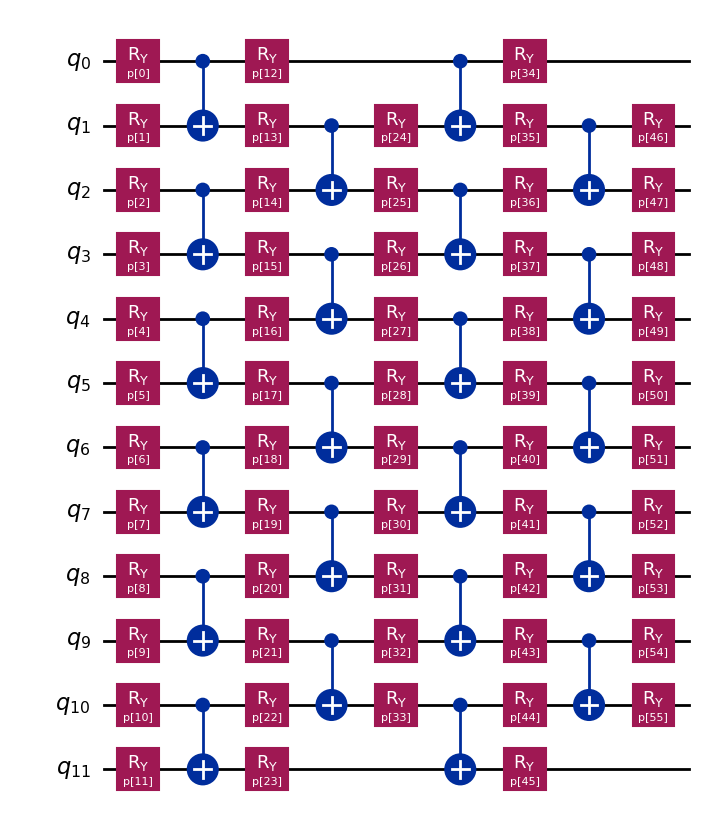

In [14]:
num_reps = 2
build_hwe_circuit(ham.num_qubits,num_reps).draw('mpl')

In [15]:
folder = "C:/some/folder"
identifyer = "hwe"

num_reps=2
penalty=False
penalty_strength = 0.25

path = run_hwe(
    folder, identifyer, laminate, target_stack, 
    encoding, dyad_ops, num_reps,
    penalty,penalty_strength=penalty_strength,constraint_matrix=constraint_matrix,
    optimizer='BFGS',optimizer_options={'maxiter':1000},
    sweep_inward=True, num_sweeps = 2,
    x0=None
)
path

'C:/some/folder/hwe_reps_2_trial_0000.hdf5'

In [16]:
with nx.nxload(path) as f:
    print(f.tree)

root:NXroot
  optimize_results:NXgroup
    fun = float64(2x11)
    nit = int32(2x11)
    par_inds = int32(2x11x10)
    qubits = int32(2x11x2)
    status = int32(2x11)
    success = bool(2x11)
    x = float64(2x11x10)
  properties:NXgroup
    @num_angles = 4
    @num_plies = 6
    @num_reps = 2
    @num_sweeps = 2
    @optimizer = 'BFGS'
    @optimizer_options = '{'maxiter': 1000}'
    @penalty = False
    @sweep_inward = True
    encoding = int32(4x2)
    laminate.funcs = float64(4x3)
    laminate.weights = float64(2x6)
    target_parameters = float64(2x3)
    target_stack = int32(6)
    x0 = float64(56)
  results:NXgroup
    @basis_state = '000110101110'
    @is_exact = False
    @is_valid = True
    @rmse = 0.42076176916673225
    lamination_parameters = float64(2x3)
    parameters = float64(56)
    stack = int32(6)
